In [198]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [199]:
df = pd.read_csv('bank_marketing.csv')

1) Prepare the data set: identify Y (there is one Y in the marketing data).

In [200]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,51,management,married,tertiary,no,6530,yes,no,unknown,5,may,91,1,-1,0,unknown,no
1,27,unemployed,married,primary,no,7459,yes,no,unknown,9,may,407,2,-1,0,unknown,no
2,59,management,divorced,primary,no,13308,yes,no,unknown,13,may,131,1,-1,0,unknown,no
3,48,technician,married,secondary,no,7373,yes,no,unknown,14,may,126,1,-1,0,unknown,no
4,51,blue-collar,married,secondary,no,7180,yes,no,unknown,14,may,927,1,-1,0,unknown,yes


In [201]:
#look at categorical attributes
for col in df.select_dtypes(include='object').columns:
    print(col)
    print(df[col].unique())

job
['management' 'unemployed' 'technician' 'blue-collar' 'admin' 'services'
 'self-employed' 'housemaid' 'unknown' 'retired' 'entrepreneur' 'student']
marital
['married' 'divorced' 'single']
education
['tertiary' 'primary' 'secondary' 'unknown']
default
['no' 'yes']
housing
['yes' 'no']
loan
['no' 'yes']
contact
['unknown' 'cellular' 'telephone']
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'jan' 'feb' 'mar' 'apr' 'sep' 'dec']
poutcome
['unknown' 'failure' 'other' 'success']
y
['no' 'yes']


In [202]:
df.y.value_counts()

no     31005
yes     4129
Name: y, dtype: int64

In [208]:
#class balance
class_bal = df.y.value_counts()/df.y.count()
class_bal

no     0.882479
yes    0.117521
Name: y, dtype: float64

In [210]:
# calculate the entropy for a dataset
from math import log2

# calculate the entropy for the split in the dataset
def entropy(y_class, class1):
    return - (y_class * log2(y_class) + n_class * log2(n_class))

entropy(class_bal['yes'], class_bal['no'])

0.5221942476471935

An entropy of 0 bits indicates a dataset containing one class;   
an entropy of 1 or more bits suggests maximum entropy for a balanced dataset (depending on the number of classes),   
with values in between indicating levels between these extremes.  

Information gain provides a way to use entropy to calculate how a change to the dataset impacts the purity of the dataset, e.g. the distribution of classes. A smaller entropy suggests more purity or less surprise.

https://machinelearningmastery.com/information-gain-and-mutual-information/#:~:text=Information%20gain%20is%20calculated%20by,when%20applied%20to%20variable%20selection.

In [175]:
#remove outliers
df.drop(df[(df['balance']>40000)|(df['balance']<0)].index,inplace=True,axis=0) # negative bank balances
df.drop(df[df['duration']>3000].index,inplace=True,axis=0) #outliers on large duration (skews data the higher the duration is)
df.drop(df[df['campaign']>30].index,axis=0,inplace=True) #drop campaign outliers

In [176]:
#drop unnecessary attributes
df.drop("pdays",inplace=True,axis=1)
df.drop(df[df['previous']>30].index,axis=0,inplace=True)

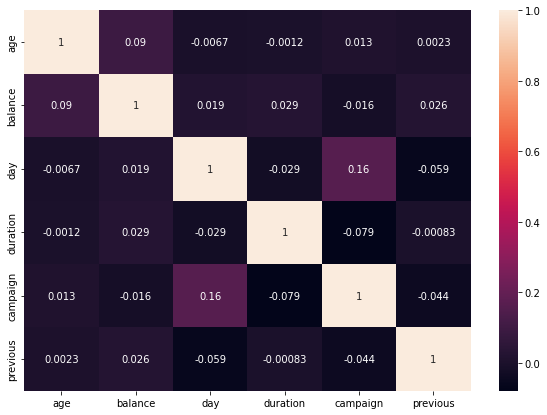

In [177]:
df_num = df[['age', 'balance', 'day', 'duration', 'campaign', 'previous']]
plt.figure(figsize=(10,7))
sns.heatmap(data=df_num.corr(), annot=True)
plt.show()

Label Encoding for Categorical Features

We have several attributes with more than 2 categories

In [178]:
#create dict for binary encoding
dic = {"yes":1,"no":0}

binary_dict = {"yes":1,"no":0}
binary_attributes = ["y","loan","default","housing"]
for i in binary_attributes:
    df[i] = df[i].map(binary_dict)
    

# Ordinal Encoding
ordinal_attributes=['month',"contact","poutcome"]
for i in ordinal_attributes:
    le=LabelEncoder()
    df[i]=le.fit_transform(df[i].values)

# OneHot Encoding 
df = pd.get_dummies(df, columns = ['job','marital','education'])

In [179]:
df

,age,default,balance,housing,loan,contact,day,month,duration,campaign,...,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown
0,51,0,6530,1,0,2,5,8,91,1,...,0,0,0,0,1,0,0,0,1,0
1,27,0,7459,1,0,2,9,8,407,2,...,0,1,0,0,1,0,1,0,0,0
2,59,0,13308,1,0,2,13,8,131,1,...,0,0,0,1,0,0,1,0,0,0
3,48,0,7373,1,0,2,14,8,126,1,...,1,0,0,0,1,0,0,1,0,0
4,51,0,7180,1,0,2,14,8,927,1,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35129,51,0,825,0,0,0,17,9,977,3,...,1,0,0,0,1,0,0,0,1,0
35130,71,0,1729,0,0,0,17,9,456,2,...,0,0,0,1,0,0,1,0,0,0
35131,72,0,5715,0,0,0,17,9,1127,5,...,0,0,0,0,1,0,0,1,0,0
35132,57,0,668,0,0,1,17,9,508,4,...,0,0,0,0,1,0,0,1,0,0


In [180]:
df=df.reset_index()
df.drop('index',axis=1,inplace=True)
df

,age,default,balance,housing,loan,contact,day,month,duration,campaign,...,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown
0,51,0,6530,1,0,2,5,8,91,1,...,0,0,0,0,1,0,0,0,1,0
1,27,0,7459,1,0,2,9,8,407,2,...,0,1,0,0,1,0,1,0,0,0
2,59,0,13308,1,0,2,13,8,131,1,...,0,0,0,1,0,0,1,0,0,0
3,48,0,7373,1,0,2,14,8,126,1,...,1,0,0,0,1,0,0,1,0,0
4,51,0,7180,1,0,2,14,8,927,1,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32076,51,0,825,0,0,0,17,9,977,3,...,1,0,0,0,1,0,0,0,1,0
32077,71,0,1729,0,0,0,17,9,456,2,...,0,0,0,1,0,0,1,0,0,0
32078,72,0,5715,0,0,0,17,9,1127,5,...,0,0,0,0,1,0,0,1,0,0
32079,57,0,668,0,0,1,17,9,508,4,...,0,0,0,0,1,0,0,1,0,0


Data Preprocessing

In [181]:
X = df.drop('y',axis=1)
y = df['y']

In [182]:
y

0        0
1        0
2        0
3        0
4        1
        ..
32076    1
32077    1
32078    1
32079    0
32080    0
Name: y, Length: 32081, dtype: int64

In [183]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size= 0.2,random_state=100)

rfc = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=100, max_leaf_nodes=50)
rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, max_leaf_nodes=50, n_estimators=50,
                       random_state=100)

In [187]:
print('Report:\n',classification_report(y_test, y_pred))
print("F1 Score:",f1_score(y_pred,y_test))
print('confusion Matrix:\n',confusion_matrix(y_pred,y_test))
print('cross validation:',cross_val_score(rfc, X, y, cv=5))

Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94      5673
           1       0.70      0.03      0.05       744

    accuracy                           0.89      6417
   macro avg       0.80      0.51      0.49      6417
weighted avg       0.87      0.89      0.84      6417

F1 Score: 0.04928664072632945
confusion Matrix:
 [[5665  725]
 [   8   19]]
cross validation: [0.87751286 0.87718204 0.87484414 0.8026808  0.82995636]


In [148]:
y_pred = rfc.predict(X_test)

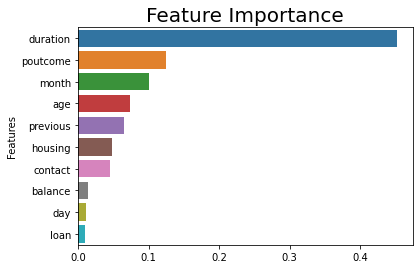

In [188]:
importances=rfc.feature_importances_
feature_importances=pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances[0:10], y=feature_importances.index[0:10])
plt.title('Feature Importance', size=20)
plt.ylabel("Features")
plt.show()

In [189]:
########### mutual infor stuff https://towardsdatascience.com/feature-selection-using-random-forest-26d7b747597f
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [190]:
sel.get_support()

array([ True, False,  True, False, False, False,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

In [191]:
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['age', 'balance', 'day', 'month', 'duration', 'campaign', 'previous',
       'poutcome'],
      dtype='object')


In [194]:
len(selected_feat)

8

In [196]:
from sklearn.feature_selection import mutual_info_classif
res = dict(zip(X_train.columns,
               mutual_info_classif(X, y, discrete_features=True)
               ))
print(res)

{'age': 0.01459017378898925, 'default': 0.0001311213312308818, 'balance': 0.09584376718000626, 'housing': 0.010323261779055876, 'loan': 0.002602816474885486, 'contact': 0.013578884024392224, 'day': 0.005878935578473118, 'month': 0.02465178472474771, 'duration': 0.09913313856249573, 'campaign': 0.004481280516053874, 'previous': 0.012948587836107318, 'poutcome': 0.03019403618594957, 'job_admin': 1.049309068031079e-05, 'job_blue-collar': 0.0030140618122596885, 'job_entrepreneur': 0.0002201454846460331, 'job_housemaid': 0.00021289539450190624, 'job_management': 0.0005592955406882455, 'job_retired': 0.0027276815051439987, 'job_self-employed': 2.109206428679844e-07, 'job_services': 0.0004956839039181107, 'job_student': 0.0023880591652553143, 'job_technician': 5.486985438746261e-05, 'job_unemployed': 0.00026964357024561805, 'job_unknown': 1.369830378798037e-07, 'marital_divorced': 3.9245862874653925e-06, 'marital_married': 0.0019053190608893933, 'marital_single': 0.0020553909434469775, 'educa

In [197]:
def ig(class_, feature):
  classes = set(class_)

  Hc = 0
  for c in classes:
    pc = list(class_).count(c)/len(class_)
    Hc += - pc * math.log(pc, 2)
  print('Overall Entropy:', Hc)
  feature_values = set(feature)

  Hc_feature = 0
  for feat in feature_values:

    pf = list(feature).count(feat)/len(feature)
    indices = [i for i in range(len(feature)) if feature[i] == feat]
    clasess_of_feat = [class_[i] for i in indices]
    for c in classes:
        pcf = clasess_of_feat.count(c)/len(clasess_of_feat)
        if pcf != 0:
            temp_H = - pf * pcf * math.log(pcf, 2)
            Hc_feature += temp_H
  ig = Hc - Hc_feature
  return ig    




3) Your job is to create TWO trees: 
- one with selecting the next X variable (at each level) with mutual information
- another with the standard mutual information.

4) Compare the performances of the two trees and see if one is better.

5) Obviously you need to program 2 Python functions that may be called to calculate either mutual information or the standard mutual information as needed. You would have to call one of them at every level to split the tree further.

6) In my opinion, once a tree is done, a forrest is easily created and the performance the forest may be evaluated comparatively with the others. But if you find it difficult, you may only do a simple tree.

7) An alternative approach would be to 
- (a) choose a package of random forest, which by default uses mutual information to select X variables at each tree node
- (b) swap out the mutual information by the (your own function of the standard mutual information).
- This way you would have 2 forests and then you can compare them.